### 分類任務
使用bert-base-chinese模型對新聞資料集做embeddings，接著訓練分類器。（參考week7程式碼）

In [22]:
!pip install seaborn

In [26]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import re
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn import svm
from matplotlib import font_manager

In [3]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
from sentence_transformers import SentenceTransformer, models, util

In [24]:
font_path = '/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


In [5]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [8]:
udn = pd.read_csv("/東森新聞.csv")
udn.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,慢活安平古城 最美富人灣凌空景觀宅、訂金到交屋自備78萬起｜東森新聞,https://news.ebc.net.tw/news/article/365123,2023-05-05 14:00:00,財經,台南安平區除有歷史悠久的古蹟外，開發近20年的「五期重劃區」兼具生活機能及「慢活」悠閒步調，...,EBC
1,2,巴菲特讚台積電了不起 但投資日本比台灣自在｜東森新聞,https://news.ebc.net.tw/news/article/365550,2023-05-08 11:30:00,財經,美國「股神」巴菲特（WarrenBuffet）今天盛讚台積電是「了不起的公司」，但承認旗下波...,EBC
2,3,期交所+金融機構送愛 捐贈金額7500萬創高｜東森新聞,https://news.ebc.net.tw/news/article/365827,2023-05-10 17:31:00,財經,"為了幫助弱勢族群，期交所攜手金融機構辦理食物銀行，捐贈食物和生活用品，今年總捐贈金額更達7,...",EBC


In [9]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,慢活安平古城最美富人灣凌空景觀宅訂金到交屋自備萬起東森新聞台南安平區除有歷史悠久的古蹟外開發...,https://news.ebc.net.tw/news/article/365123,財經
1,巴菲特讚台積電了不起但投資日本比台灣自在東森新聞美國股神巴菲特今天盛讚台積電是了不起的公司但...,https://news.ebc.net.tw/news/article/365550,財經
2,期交所金融機構送愛捐贈金額萬創高東森新聞為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食...,https://news.ebc.net.tw/news/article/365827,財經
3,大反攻講中文也通東森新聞今天舉辦年度開發者大會發表款硬體新產品包括中階手機折疊手機及平板電腦...,https://news.ebc.net.tw/news/article/365885,財經
4,車款遭拒保國泰產險開第一槍傳富邦擬跟進東森新聞日前一輛新車因停車格塌陷而爆出新竹天坑事件以及...,https://news.ebc.net.tw/news/article/366027,財經


In [10]:
udn["embeddings"] = udn.content.apply(lambda x: bert_ch.encode(x))
udn.head(3)

,content,artUrl,artCatagory,embeddings
0,慢活安平古城最美富人灣凌空景觀宅訂金到交屋自備萬起東森新聞台南安平區除有歷史悠久的古蹟外開發...,https://news.ebc.net.tw/news/article/365123,財經,"[0.47601634, -0.053217046, -0.21419242, 0.2369..."
1,巴菲特讚台積電了不起但投資日本比台灣自在東森新聞美國股神巴菲特今天盛讚台積電是了不起的公司但...,https://news.ebc.net.tw/news/article/365550,財經,"[0.44002932, -0.0763511, -0.3355454, 0.1933778..."
2,期交所金融機構送愛捐贈金額萬創高東森新聞為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食...,https://news.ebc.net.tw/news/article/365827,財經,"[0.41917017, -0.083233975, -0.3118952, 0.08266..."


In [11]:
import numpy as np
from ast import literal_eval

In [12]:
data = udn.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
5636  0.472677 -0.063040 -0.207096  0.468632  0.082245 -0.194532  0.070398   
4537  0.581944  0.059837 -0.429350  0.087765  0.183808  0.113331  0.095177   
8036  0.503957 -0.219937 -0.205075  0.185380 -0.021624 -0.107964 -0.136033   
5977  0.367118 -0.030257 -0.374182  0.180600 -0.022829 -0.212200 -0.058639   
7134  0.655991 -0.189751 -0.063081  0.359305  0.191269 -0.030497 -0.223862   

           7         8         9    ...       758       759       760  \
5636  0.276750 -0.159544 -0.098925  ... -0.004793 -0.199902  0.111202   
4537  0.237974 -0.076291 -0.223839  ...  0.383611 -0.174575  0.254120   
8036 -0.012050 -0.298671 -0.204973  ...  0.156765 -0.284814  0.294269   
5977  0.201665 -0.214076 -0.209923  ...  0.194884 -0.249341  0.150037   
7134  0.017689 -0.213759 -0.239864  ... -0.105847 -0.071854 -0.073976   

           761       762       763       764       765       766       767  
5636 -0.014714 

In [13]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba[:10])
print(y_pred[:10])

[[1.86861954e-05 9.99868144e-01 8.14775812e-05 3.16921961e-05]
 [1.02331709e-08 9.99999793e-01 1.39597403e-08 1.82511825e-07]
 [4.08136251e-04 3.16454533e-05 9.99098405e-01 4.61812972e-04]
 [1.07323738e-05 9.99914887e-01 4.64598367e-05 2.79206640e-05]
 [4.27387507e-06 9.99597545e-01 3.82524102e-04 1.56571485e-05]
 [3.97017975e-07 9.99972978e-01 2.51460841e-05 1.47920761e-06]
 [6.04394729e-06 9.96403042e-01 1.90049605e-03 1.69041830e-03]
 [7.62290296e-08 9.99999154e-01 3.40854636e-07 4.29257613e-07]
 [3.80718803e-06 9.99926306e-01 3.62157623e-05 3.36710756e-05]
 [3.99202909e-04 1.03965023e-04 2.09825033e-04 9.99287007e-01]]
['政治' '政治' '財經' '政治' '政治' '政治' '政治' '政治' '政治' '體育']


In [15]:
from sklearn.metrics import classification_report

In [16]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          健康       1.00      0.99      0.99       296
          政治       0.99      0.99      0.99      1500
          財經       0.95      0.96      0.95       239
          體育       0.98      0.98      0.98       428

    accuracy                           0.98      2463
   macro avg       0.98      0.98      0.98      2463
weighted avg       0.98      0.98      0.98      2463



我們猜測"健康"的準確度特別高的原因可能為此類新聞的用詞、主題較為明確，像是：醫師、疾病名稱、治療等，因此比較不容易被辨識成其他種類的新聞。

此外，我們發現其他分類的結果也不錯，推測是這些類別的新聞內容都較為特定。

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '健康'),
  Text(0, 1.5, '政治'),
  Text(0, 2.5, '財經'),
  Text(0, 3.5, '體育')])

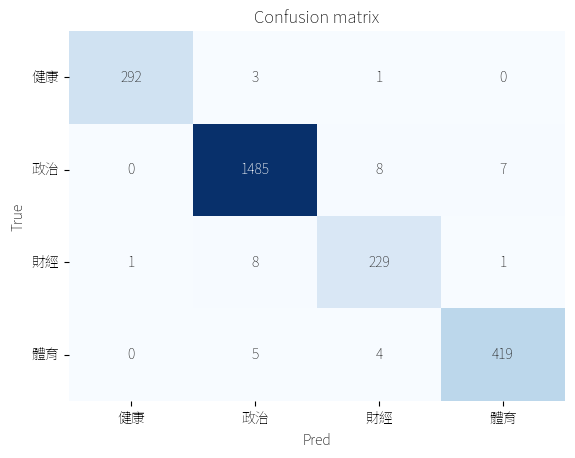

In [27]:
#print confusion matrix
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False, annot_kws={"fontsize": 10})
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)